# Packages 

In [1]:
import cv2
import dlib
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from PIL import Image
import shutil
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

# dataset loading

In [3]:
dataset_path = 'facial expressions'  #dataset path
image_paths = [os.path.join(dataset_path, img_name) for img_name in os.listdir(dataset_path)]

images = []
for path in image_paths:
    with Image.open(path) as img:
        images.append(img)


# Preprocessing

In [4]:
def preprocess_images(image_paths, new_width, new_height, save_path):
    resized_images = []
    for path in tqdm(image_paths, desc='Preprocessing', unit='image'):
        image = cv2.imread(path)
        resized_image = cv2.resize(image, (new_width, new_height))
        resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)  
        
        # Save the preprocessed image
        filename = os.path.basename(path)
        save_filename = os.path.join(save_path, filename)
        cv2.imwrite(save_filename, resized_image)
        
        resized_images.append(resized_image)
    return resized_images


In [5]:
dataset_path = 'facial expressions'  
image_paths = [os.path.join(dataset_path, img_name) for img_name in os.listdir(dataset_path)]
labels = [os.path.basename(path) for path in image_paths]  
new_width, new_height = 100, 100  # Define desired dimensions for preprocessing
preprocessed_save_path = 'preprocessed_images'
processed_images = preprocess_images(image_paths, new_width, new_height, preprocessed_save_path)

Preprocessing: 100%|████████████████████████████████████████████████████████████| 601/601 [00:00<00:00, 2352.23image/s]


# Feature Extraction

In [8]:
def compute_lbp(image, radius=3, neighbors=8):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = np.zeros_like(gray)

    for i in range(len(gray) - radius):
        for j in range(len(gray[i]) - radius):
            center = gray[i, j]
            code = 0
            for a in range(neighbors):
                x = i + int(radius * np.cos(2 * np.pi * a / neighbors))
                y = j - int(radius * np.sin(2 * np.pi * a / neighbors))

                if gray[x, y] >= center:
                    code |= (1 << a)

            lbp[i, j] = code

    return lbp

def extract_features_with_labels(images, labels):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('expressions.dat')

    features_list = []
    for i, img in tqdm(enumerate(images), desc='Extracting Features', unit='image'):
        label = labels[i]  # Extract the  label for the current image
        
        # Detect faces
        faces = detector(img)
        for face in faces:
            # Extract facial landmarks
            landmarks = predictor(img, face)
            
            # Extract texture patterns 
            lbp_radius = 3
            lbp_neighbors = 8
            lbp = compute_lbp(img, lbp_radius, lbp_neighbors)  
            
            # Append texture pattern to features_list
            hist_r = cv2.calcHist([img], [0], None, [256], [0, 256])  # Red channel histogram
            hist_g = cv2.calcHist([img], [1], None, [256], [0, 256])  # Green channel histogram
            hist_b = cv2.calcHist([img], [2], None, [256], [0, 256])  # Blue channel histogram
            combined_features = {
                'landmarks': landmarks,
                'lbp_pattern': lbp,
                'color_histograms': np.concatenate([hist_r, hist_g, hist_b], axis=0),
                'label': label  # Include the label with the features
            }
            features_list.append(combined_features)

    return features_list
def save_extracted_features(features, save_path):
    for i, feature in enumerate(features):
        filename = f"feature_{i}.npy"
        save_filename = os.path.join(save_path, filename)
        np.save(save_filename, feature)


In [10]:
features_save_path = 'extracted_features'
extracted_features = extract_features_with_labels(processed_images, labels)
save_extracted_features(extracted_features, features_save_path)
images = [feature['lbp_pattern'] for feature in extracted_features]
labels = [feature['label'].split(' (')[0] for feature in extracted_features]

Extracting Features: 601image [03:03,  3.27image/s]


In [11]:
def GPbCNM(images, labels, image_height, image_width, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),  # Adding dropout for regularization
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

    train_images = np.array(train_images) / 255.0
    val_images = np.array(val_images) / 255.0

    history = model.fit(train_images, np.array(train_labels), batch_size=16, epochs=75, verbose=1, validation_data=(val_images, np.array(val_labels)))


    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    print(f"Train Accuracy: {train_acc[-1]:.4f}")
    print(f"Train Loss: {train_loss[-1]:.4f}")
    
# Plot Training Accuracy
    plt.figure(figsize=(6, 6))

    plt.plot(train_acc, label='Training Accuracy', color='blue')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
# Plot Training Loss
    plt.figure(figsize=(6, 6))
    plt.plot(train_loss, label='Training Loss', color='green')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    model.save('facial_expression_model.keras')

    return model, history, val_loss, val_acc

Epoch 1/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 235ms/step - accuracy: 0.1672 - loss: 1.9160 - val_accuracy: 0.1571 - val_loss: 1.7908
Epoch 2/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - accuracy: 0.2446 - loss: 1.7902 - val_accuracy: 0.2714 - val_loss: 1.7876
Epoch 3/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - accuracy: 0.1981 - loss: 1.7868 - val_accuracy: 0.1714 - val_loss: 1.7904
Epoch 4/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.2167 - loss: 1.7845 - val_accuracy: 0.2857 - val_loss: 1.7736
Epoch 5/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - accuracy: 0.2046 - loss: 1.7695 - val_accuracy: 0.1286 - val_loss: 1.7829
Epoch 6/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 267ms/step - accuracy: 0.2321 - loss: 1.7404 - val_accuracy: 0.2143 - val_loss: 1.7610
Epoch 7/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.2896 - loss: 1.6473 - val_accuracy: 0.1571 - val_loss: 1.8247
Epoch 8/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.4491 - loss: 1.4570 - val_accuracy: 0.

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - accuracy: 0.9901 - loss: 0.0540 - val_accuracy: 0.1714 - val_loss: 6.9058
Epoch 52/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.9924 - loss: 0.0505 - val_accuracy: 0.1714 - val_loss: 6.9202
Epoch 53/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.9788 - loss: 0.0581 - val_accuracy: 0.2429 - val_loss: 6.0157
Epoch 54/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - accuracy: 0.9645 - loss: 0.1180 - val_accuracy: 0.2714 - val_loss: 6.3074
Epoch 55/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.9873 - loss: 0.0416 - val_accuracy: 0.2714 - val_loss: 6.2041
Epoch 56/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.9811 - loss: 0.0539 - val_accuracy: 0.2429 - val_loss: 4.9803
Epoch 57/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.9791 - loss: 0.0561 - val_accuracy: 0.1857 - val_loss: 5.7068
Epoch 58/75
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - accuracy: 0.9879 - loss: 0.0569 - val_accuracy: 0.2000

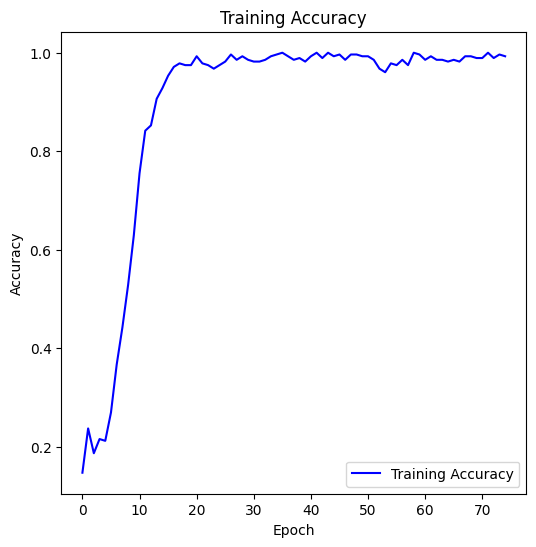

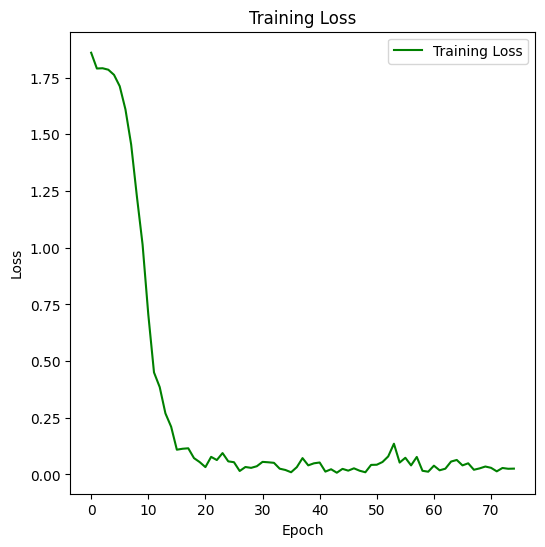

In [12]:
emotions = ['Angry', 'happy', 'neutral', 'surprise', 'sad', 'fear']
images = [np.expand_dims(img, axis=-1) for img in images]
images = [np.concatenate([img, img, img], axis=-1) for img in images]
images = np.array(images).reshape(-1, new_height, new_width, 3)
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
folder_path = 'features'
images_train, images_test, labels_train, labels_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)
num_classes = len(set(labels))
label_encoder = LabelEncoder()
encoded_labels_train = label_encoder.fit_transform(labels_train)
model, history, test_loss, test_acc = GPbCNM(images_train, encoded_labels_train, new_height, new_width, num_classes)

In [13]:
# Load the trained model for predictions
loaded_model = load_model('facial_expression_model.keras')
# Use the loaded model to predict facial expressions on test images
train_predictions = loaded_model.predict(images_train)
predicted_classes = np.argmax(train_predictions, axis=1)
expressionss = ['Angry', 'Sad','fear'] 
class_names = ['Angry', 'Happy', 'Neutral', 'Surprise', 'Sad', 'Fear']
for i, (predicted_class, actual_label_index) in enumerate(zip(predicted_classes, labels_train)):
    predicted_expression = class_names[predicted_class]
    actual_expression = class_names[actual_label_index]
    print(f"Image {i + 1}: Predicted Expression - {predicted_expression}, Actual Expression - {actual_expression}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Image 1: Predicted Expression - Happy, Actual Expression - Happy
Image 2: Predicted Expression - Fear, Actual Expression - Fear
Image 3: Predicted Expression - Angry, Actual Expression - Angry
Image 4: Predicted Expression - Neutral, Actual Expression - Neutral
Image 5: Predicted Expression - Sad, Actual Expression - Sad
Image 6: Predicted Expression - Neutral, Actual Expression - Surprise
Image 7: Predicted Expression - Neutral, Actual Expression - Neutral
Image 8: Predicted Expression - Happy, Actual Expression - Happy
Image 9: Predicted Expression - Fear, Actual Expression - Fear
Image 10: Predicted Expression - Sad, Actual Expression - Surprise
Image 11: Predicted Expression - Sad, Actual Expression - Sad
Image 12: Predicted Expression - Happy, Actual Expression - Happy
Image 13: Predicted Expression - Fear, Actual Expression - Fear
Image 14: Predicted Expression - Angry, Actual Expression - Angry
Image 15: Predicted Expression - Angry, Actua

In [14]:
 # Function to determine stress based on facial expressions
def detect_stress(predicted_expression):
    if predicted_expression in expressionss:
        return 'Stress'
    else:
        return 'Non-Stress'
# Loop through predicted expressions and categorize stress
for i, (predicted_class, actual_label_index) in enumerate(zip(predicted_classes, labels_train)):
    predicted_expression = class_names[predicted_class]
    actual_expression = class_names[actual_label_index]

    # Determine stress based on predicted expression
    stress_category = detect_stress(predicted_expression)
    
    print(f"Image {i + 1}: Predicted Expression - {predicted_expression}, Stress Category - {stress_category}")


Image 1: Predicted Expression - Happy, Stress Category - Non-Stress
Image 2: Predicted Expression - Fear, Stress Category - Non-Stress
Image 3: Predicted Expression - Angry, Stress Category - Stress
Image 4: Predicted Expression - Neutral, Stress Category - Non-Stress
Image 5: Predicted Expression - Sad, Stress Category - Stress
Image 6: Predicted Expression - Neutral, Stress Category - Non-Stress
Image 7: Predicted Expression - Neutral, Stress Category - Non-Stress
Image 8: Predicted Expression - Happy, Stress Category - Non-Stress
Image 9: Predicted Expression - Fear, Stress Category - Non-Stress
Image 10: Predicted Expression - Sad, Stress Category - Stress
Image 11: Predicted Expression - Sad, Stress Category - Stress
Image 12: Predicted Expression - Happy, Stress Category - Non-Stress
Image 13: Predicted Expression - Fear, Stress Category - Non-Stress
Image 14: Predicted Expression - Angry, Stress Category - Stress
Image 15: Predicted Expression - Angry, Stress Category - Stress
I

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


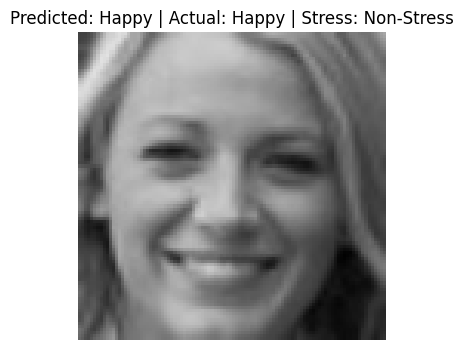

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


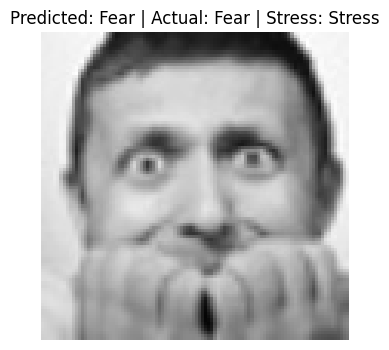

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


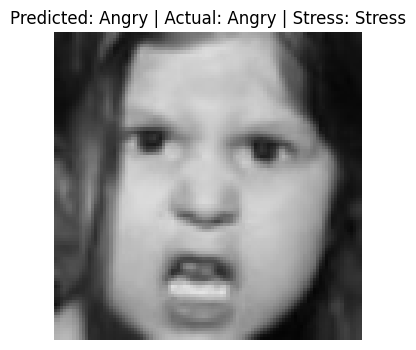

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


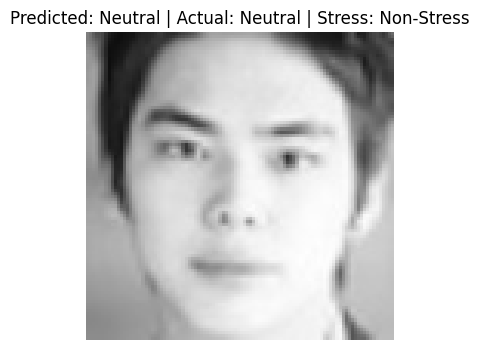

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


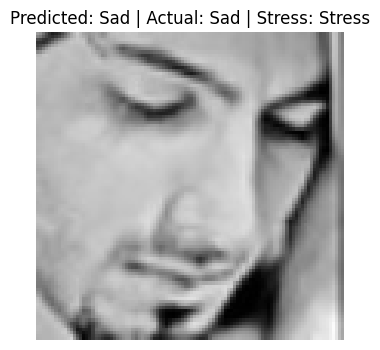

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


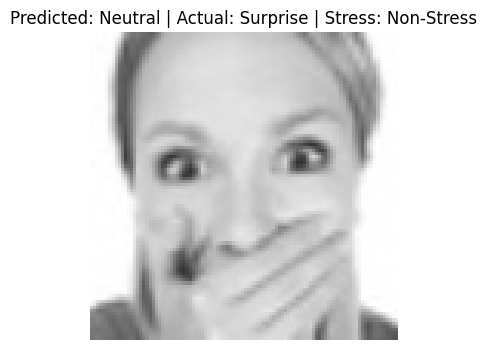

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


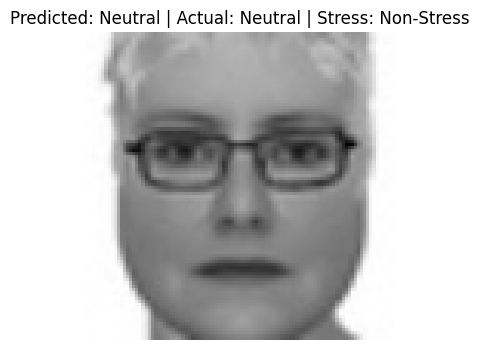

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


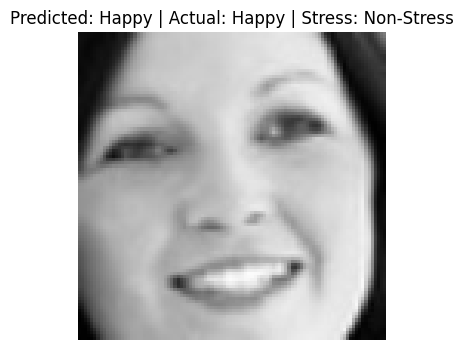

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


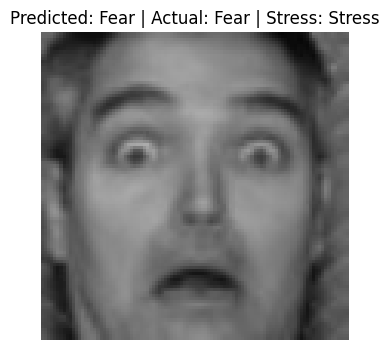

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


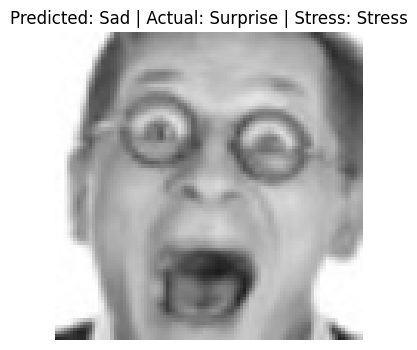

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


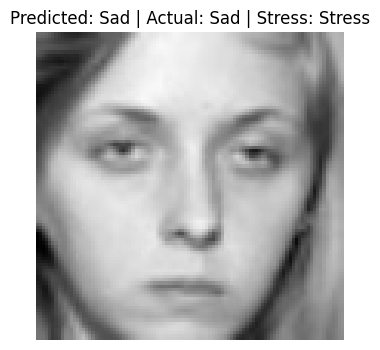

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


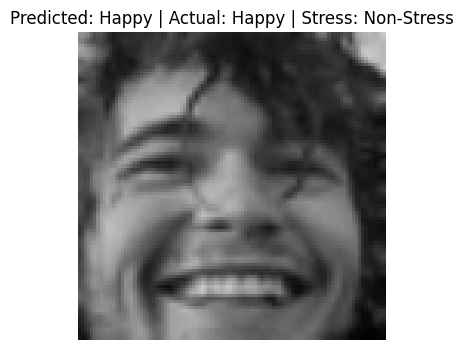

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


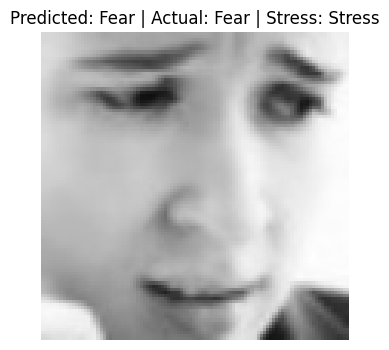

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


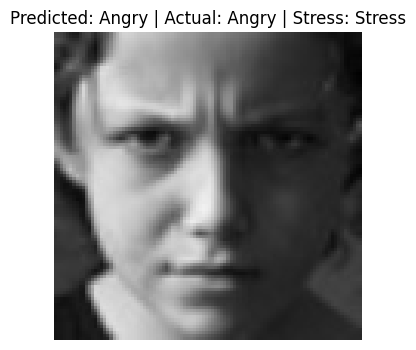

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


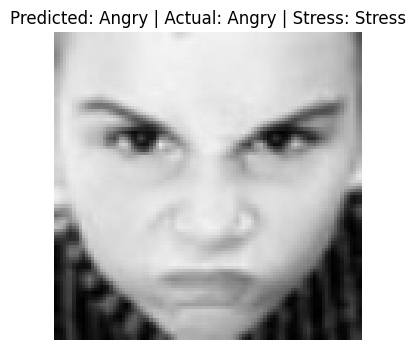

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


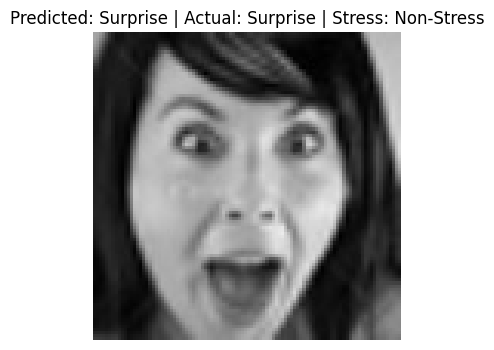

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


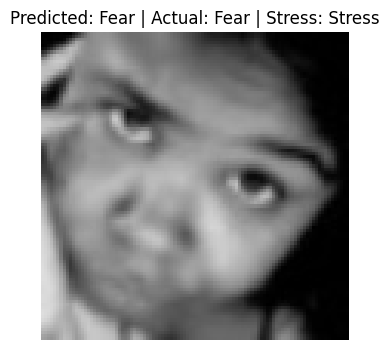

In [16]:
folder_path = 'independent_testimages'
def detect_stress(predicted_expression):
    expressionss = ['Angry', 'Sad', 'Fear']
    if predicted_expression in expressionss:
        return 'Stress'
    else:
        return 'Non-Stress'
provided_images = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(('.jpg', '.png', '.jpeg'))]
for i, image_path in enumerate(provided_images):
    image = plt.imread(image_path)
    predicted_class = np.argmax(loaded_model.predict(np.expand_dims(images_train[i], axis=0)))
    predicted_expression = class_names[predicted_class]
    actual_expression = class_names[labels_train[i]]
    stress_category = detect_stress(predicted_expression)
    plt.figure(figsize=(4, 4))  
    plt.imshow(image) 
    plt.title(f"Predicted: {predicted_expression} | Actual: {actual_expression} | Stress: {stress_category}", fontsize=12)
    plt.axis('off')
    plt.show()

In [17]:
train_predictions = model.predict(images_train)
predicted_classes = np.argmax(train_predictions, axis=1)
correct_predictions = np.sum(predicted_classes == labels_train)
accuracy = correct_predictions/3
total_images = len(labels_train)
print(f"Prediction Expression Accuracy using trained model: {accuracy:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
Prediction Expression Accuracy using trained model: 98.3333


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


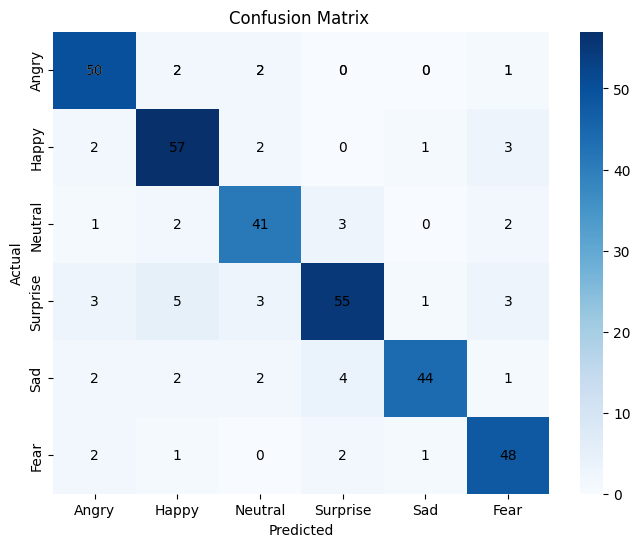

In [18]:

train_predictions = model.predict(images_train)
predicted_classes_train = np.argmax(train_predictions, axis=1)
conf_matrix_train = confusion_matrix(labels_train, predicted_classes_train)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
# Add text to each cell
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j + 0.5, i + 0.5, conf_matrix_train[i, j], ha='center', va='center', color='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix ')
plt.show()

In [19]:
report = classification_report(labels_train, predicted_classes_train, target_names=class_names)
print(report)


              precision    recall  f1-score   support

       Angry       0.83      0.91      0.87        55
       Happy       0.83      0.88      0.85        65
     Neutral       0.82      0.84      0.83        49
    Surprise       0.86      0.79      0.82        70
         Sad       0.94      0.80      0.86        55
        Fear       0.83      0.89      0.86        54

    accuracy                           0.85       348
   macro avg       0.85      0.85      0.85       348
weighted avg       0.85      0.85      0.85       348

